In [0]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader
from tqdm import tqdm

n_cpu = multiprocessing.cpu_count()
MAX_LENGTH = 256

class TextProcessor:
    def __init__(self, tokenizer, label2id: dict, clf_token, pad_token, max_length: int=512):
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length
        self.clf_token = clf_token
        self.pad_token = pad_token

    def encode(self, input):
        return list(self.tokenizer.convert_tokens_to_ids(o) for o in input)

    def token2id(self, item):
        "Convert text (item[0]) to sequence of IDs and label (item[1]) to integer"
        assert len(item) == 2   # Need a row of text AND labels
        label, text = item[0], item[1]
        assert isinstance(text, str)   # Need position 1 of input to be of type(str)
        inputs = self.tokenizer.tokenize(text)
        # Trim or pad dataset
        if len(inputs) >= self.max_length:
            inputs = inputs[:self.max_length - 1]
            ids = self.encode(inputs) + [self.clf_token]
        else:
            pad = [self.pad_token] * (self.max_length - len(inputs) - 1)
            ids = self.encode(inputs) + [self.clf_token] + pad

        return np.array(ids, dtype='int64'), self.label2id[label]

    def process_row(self, row):
        "Calls the token2id method of the text processor for passing items to executor"
        return self.token2id((row[1][LABEL_COL], row[1][TEXT_COL]))

    def create_dataloader(self,
                          df: pd.DataFrame,
                          batch_size: int = 32,
                          shuffle: bool = False,
                          valid_pct: float = None):
        "Process rows in pd.DataFrame using n_cpus and return a DataLoader"

        tqdm.pandas()
        with ProcessPoolExecutor(max_workers=n_cpu) as executor:
            result = list(
                tqdm(executor.map(self.process_row, df.iterrows(), chunksize=8192),
                     desc=f"Processing {len(df)} examples on {n_cpu} cores",
                     total=len(df)))

        features = [r[0] for r in result]
        labels = [r[1] for r in result]

        dataset = TensorDataset(torch.tensor(features, dtype=torch.long),
                                torch.tensor(labels, dtype=torch.long))

        data_loader = DataLoader(dataset,
                                 batch_size=batch_size,
                                 num_workers=0,
                                 shuffle=shuffle,
                                 pin_memory=torch.cuda.is_available())
        return data_loader

In [0]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_embeddings, num_max_positions, num_heads, num_layers, dropout, causal):
        super().__init__()
        self.causal = causal
        self.tokens_embeddings = nn.Embedding(num_embeddings, embed_dim)
        self.position_embeddings = nn.Embedding(num_max_positions, embed_dim)
        self.dropout = nn.Dropout(dropout)

        self.attentions, self.feed_forwards = nn.ModuleList(), nn.ModuleList()
        self.layer_norms_1, self.layer_norms_2 = nn.ModuleList(), nn.ModuleList()
        for _ in range(num_layers):
            self.attentions.append(nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout))
            self.feed_forwards.append(nn.Sequential(nn.Linear(embed_dim, hidden_dim),
                                                    nn.ReLU(),
                                                    nn.Linear(hidden_dim, embed_dim)))
            self.layer_norms_1.append(nn.LayerNorm(embed_dim, eps=1e-12))
            self.layer_norms_2.append(nn.LayerNorm(embed_dim, eps=1e-12))

    def forward(self, x, padding_mask=None):
        """ x has shape [seq length, batch], padding_mask has shape [batch, seq length] """
        positions = torch.arange(len(x), device=x.device).unsqueeze(-1)
        h = self.tokens_embeddings(x)
        h = h + self.position_embeddings(positions).expand_as(h)
        h = self.dropout(h)

        attn_mask = None
        if self.causal:
            attn_mask = torch.full((len(x), len(x)), -float('Inf'), device=h.device, dtype=h.dtype)
            attn_mask = torch.triu(attn_mask, diagonal=1)

        for layer_norm_1, attention, layer_norm_2, feed_forward in zip(self.layer_norms_1, self.attentions,
                                                                       self.layer_norms_2, self.feed_forwards):
            h = layer_norm_1(h)
            x, _ = attention(h, h, h, attn_mask=attn_mask, need_weights=False, key_padding_mask=padding_mask)
            x = self.dropout(x)
            h = x + h

            h = layer_norm_2(h)
            x = feed_forward(h)
            x = self.dropout(x)
            h = x + h
        return h

In [0]:
class TransformerWithClfHead(nn.Module):
    def __init__(self, config, fine_tuning_config):
        """ Transformer with a classification head. """
        super().__init__()
        self.config = fine_tuning_config
        self.transformer = Transformer(config.embed_dim, config.hidden_dim, config.num_embeddings,
                                       config.num_max_positions, config.num_heads, config.num_layers,
                                           fine_tuning_config.dropout, causal=not config.mlm)

        self.classification_head = nn.Linear(config.embed_dim, fine_tuning_config.num_classes)
        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding, nn.LayerNorm)):
            module.weight.data.normal_(mean=0.0, std=self.config.init_range)
        if isinstance(module, (nn.Linear, nn.LayerNorm)) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, x, clf_tokens_mask, lm_labels=None, clf_labels=None, padding_mask=None):
        hidden_states = self.transformer(x, padding_mask)

        clf_tokens_states = (hidden_states * clf_tokens_mask.unsqueeze(-1).float()).sum(dim=0)
        clf_logits = self.classification_head(clf_tokens_states)

        if clf_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(clf_logits.view(-1, clf_logits.size(-1)), clf_labels.view(-1))
            return clf_logits, loss

        return clf_logits

In [64]:
!wget https://home.ipipan.waw.pl/p.teisseyre/TEACHING/ZMUM/DANE/Train.csv

--2020-05-22 12:18:42--  https://home.ipipan.waw.pl/p.teisseyre/TEACHING/ZMUM/DANE/Train.csv
Resolving home.ipipan.waw.pl (home.ipipan.waw.pl)... 213.135.36.238
Connecting to home.ipipan.waw.pl (home.ipipan.waw.pl)|213.135.36.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75843916 (72M) [application/octet-stream]
Saving to: ‘Train.csv.1’

Train.csv.1         100%[===================>]  72.33M  38.2MB/s    in 1.9s    

2020-05-22 12:18:44 (38.2 MB/s) - ‘Train.csv.1’ saved [75843916/75843916]



In [0]:
!pip install -q pytorch_transformers
!pip install -q pytorch-ignite

In [66]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
class TransformerWithClfHeadAndAdapters(nn.Module):
    def __init__(self, config, fine_tuning_config):
        """ Transformer with a classification head and adapters. """
        super().__init__()
        self.config = fine_tuning_config
        if fine_tuning_config.adapters_dim > 0:
            self.transformer = TransformerWithAdapters(fine_tuning_config.adapters_dim, config.embed_dim, config.hidden_dim,
                                                       config.num_embeddings, config.num_max_positions, config.num_heads,
                                                       config.num_layers, fine_tuning_config.dropout, causal=not config.mlm)
        else:
            self.transformer = Transformer(config.embed_dim, config.hidden_dim, config.num_embeddings,
                                           config.num_max_positions, config.num_heads, config.num_layers,
                                           fine_tuning_config.dropout, causal=not config.mlm)

        self.classification_head = nn.Linear(config.embed_dim, fine_tuning_config.num_classes)
        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding, nn.LayerNorm)):
            module.weight.data.normal_(mean=0.0, std=self.config.init_range)
        if isinstance(module, (nn.Linear, nn.LayerNorm)) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, x, clf_tokens_mask, lm_labels=None, clf_labels=None, padding_mask=None):
        hidden_states = self.transformer(x, padding_mask)

        clf_tokens_states = (hidden_states * clf_tokens_mask.unsqueeze(-1).float()).sum(dim=0)
        clf_logits = self.classification_head(clf_tokens_states)

        if clf_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(clf_logits.view(-1, clf_logits.size(-1)), clf_labels.view(-1))
            return clf_logits, loss

        return clf_logits

In [68]:
import argparse
import multiprocessing
import os
import torch
from pytorch_transformers import BertTokenizer, cached_path
from pytorch_transformers.optimization import AdamW
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage, Accuracy, MeanAbsoluteError
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import PiecewiseLinear, ProgressBar
from sklearn.model_selection import train_test_split

df = pd.read_csv('Train.csv', sep = ';', encoding = 'UTF-8')

PRETRAINED_MODEL_URL = "https://s3.amazonaws.com/models.huggingface.co/naacl-2019-tutorial/"
TEXT_COL, LABEL_COL = 'opinion', 'rate'  # Column names in pd.DataFrame for sst dataset
n_cpu = multiprocessing.cpu_count()

def load_pretrained_model(args):
    "download pre-trained model and config"
    state_dict = torch.load(cached_path(os.path.join(args.model_checkpoint, "model_checkpoint.pth")),
                            map_location='cpu')
    config = torch.load(cached_path(os.path.join(args.model_checkpoint, "model_training_args.bin")))
    # Initialize model: Transformer base + classifier head
    model = TransformerWithClfHeadAndAdapters(config=config, fine_tuning_config=args).to(args.device)
    incompatible_keys = model.load_state_dict(state_dict, strict=False)
    print(f"Parameters discarded from the pretrained model: {incompatible_keys.unexpected_keys}")
    print(f"Parameters added in the model: {incompatible_keys.missing_keys}")

    if args.adapters_dim > 0:
        # Display adaptation parameters
        for name, param in model.named_parameters():
            if 'embeddings' not in name and 'classification' not in name and 'adapters_1' not in name and 'adapters_2' not in name:
                param.detach_()
                param.requires_grad = False
            else:
                param.requires_grad = True
        full_parameters = sum(p.numel() for p in model.parameters())
        trained_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"\nWe will train {trained_parameters:,} parameters out of {full_parameters:,}"
              f" (i.e. {100 * trained_parameters/full_parameters:.1f}%) of the full parameters")

    return model, state_dict, config


class HardcodedArgs():
  model_checkpoint = PRETRAINED_MODEL_URL
  dataset_path = '../data/sst'
  dataset_cache = './dataset_cache'
  logdir = './transformer_results'
  num_classes = 10
  adapters_dim = -1
  dropout = 0.1
  clf_loss_coef = 1
  train_batch_size = 32
  valid_batch_size = 32
  valid_pct = 0.1
  lr = 6.5e-5
  n_warmup = 10
  max_norm = 1.0
  weight_decay = 0.0
  n_epochs = 15
  gradient_acc_steps = 2
  init_range = 0.02
  device = "cuda" if torch.cuda.is_available() else "cpu"

parser = argparse.ArgumentParser()
parser.add_argument("--model_checkpoint", type=str, default=PRETRAINED_MODEL_URL, help="Path to the pretrained model checkpoint")
parser.add_argument("--dataset_path", type=str, default='../data/sst', help="Directory to dataset.")
parser.add_argument("--dataset_cache", type=str, default='./dataset_cache', help="Path to dataset cache")
parser.add_argument("--logdir", type=str, default='./transformer_results', help="Path to logs")
parser.add_argument("--num_classes", type=int, default=5, help="Number of classes for the target classification task")
parser.add_argument("--adapters_dim", type=int, default=-1, help="If >0 add adapters to the model with adapters_dim dimension")
parser.add_argument("--dropout", type=float, default=0.1, help="Dropout for transformer module")
parser.add_argument("--clf_loss_coef", type=float, default=1, help="If >0 add a classification loss")
parser.add_argument("--train_batch_size", type=int, default=32, help="Batch size for training")
parser.add_argument("--valid_batch_size", type=int, default=32, help="Batch size for validation")
parser.add_argument("--valid_pct", type=float, default=0.1, help="Percentage of training data to use for validation")
parser.add_argument("--lr", type=float, default=6.5e-5, help="Learning rate")
parser.add_argument("--n_warmup", type=int, default=10, help="Number of warmup iterations")
parser.add_argument("--max_norm", type=float, default=1.0, help="Clipping gradient norm")
parser.add_argument("--weight_decay", type=float, default=0.0, help="Weight decay")
parser.add_argument("--n_epochs", type=int, default=3, help="Number of training epochs")
parser.add_argument("--gradient_acc_steps", type=int, default=2, help="Number of update steps to accumulate before a backward pass.")
parser.add_argument("--init_range", type=float, default=0.02, help="Normal initialization standard deviation")

parser.add_argument("--device", type=str, default="cuda" if torch.cuda.is_available() else "cpu", help="Device (cuda or cpu)")
# args = parser.parse_args()

args = HardcodedArgs()

# Define pretrained model and optimizer
model, state_dict, config = load_pretrained_model(args)
optimizer = AdamW(model.parameters(), lr=args.lr, correct_bias=False)
num_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {num_model_params:,} parameters")

# Define datasets
df['rate'] = df.rate - 1
df_train, df_test = train_test_split(df, test_size = 0.2)
df_train, df_val = train_test_split(df_train, test_size = 0.1)
datasets = {'train': df_train, 'dev': df_val, 'test': df_test}

# Define labels
labels = list(set(datasets["train"][LABEL_COL].tolist()))
assert len(labels) == args.num_classes  # Specified number of classes should be equal to that in the given dataset!
label2int = {label: i for i, label in enumerate(labels)}
int2label = {i: label for label, i in label2int.items()}

# Get BertTokenizer for this pretrained model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
clf_token = tokenizer.vocab['[CLS]']  # classifier token
pad_token = tokenizer.vocab['[PAD]']  # pad token
processor = TextProcessor(tokenizer, label2int, clf_token, pad_token, max_length=config.num_max_positions)

train_dl = processor.create_dataloader(datasets["train"],
                                        shuffle=True,
                                        batch_size=args.train_batch_size,
                                        valid_pct=None)

valid_dl = processor.create_dataloader(datasets["dev"],
                                        batch_size=args.train_batch_size,
                                        valid_pct=None)

test_dl = processor.create_dataloader(datasets["test"],
                                      batch_size=args.valid_batch_size,
                                      valid_pct=None)

# Training function and trainer
def update(engine, batch):
    "update function for training"
    model.train()
    inputs, labels = (t.to(args.device) for t in batch)
    inputs = inputs.transpose(0, 1).contiguous()  # to shape [seq length, batch]
    _, loss = model(inputs,
                    clf_tokens_mask=(inputs == clf_token),
                    clf_labels=labels)
    loss = loss / args.gradient_acc_steps
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_norm)
    if engine.state.iteration % args.gradient_acc_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
    return loss.item()
trainer = Engine(update)

# Evaluation function and evaluator (evaluator output is the input of the metrics)
def inference(engine, batch):
    model.eval()
    with torch.no_grad():
        batch, labels = (t.to(args.device) for t in batch)
        inputs = batch.transpose(0, 1).contiguous()  # to shape [seq length, batch]
        clf_logits = model(inputs,
                            clf_tokens_mask=(inputs == clf_token),
                            padding_mask=(batch == pad_token))
    return clf_logits, labels
evaluator = Engine(inference)

# add metric to evaluator
Accuracy().attach(evaluator, "accuracy")

# add evaluator to trainer: eval on valid set after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(valid_dl)
    print(f"validation epoch: {engine.state.epoch} acc: {100*evaluator.state.metrics['accuracy']:.3f}%")

# Learning rate schedule: linearly warm-up to lr and then to zero
scheduler = PiecewiseLinear(optimizer, 'lr', [(0, 0.0), (args.n_warmup, args.lr),
                            (len(train_dl) * args.n_epochs, 0.0)])
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)

# Add progressbar with loss
RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")
ProgressBar(persist=True).attach(trainer, metric_names=['loss'])

# Save checkpoints and finetuning config
checkpoint_handler = ModelCheckpoint(args.logdir, 'checkpoint',
                                      save_interval=1, require_empty=False)
trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpoint_handler, {'sst_model': model})

# Save metadata
torch.save({
    "config": config,
    "config_ft": args,
    "int2label": int2label
}, os.path.join(args.logdir, "model2_training_args.bin"))
torch.save({
    "config": config,
    "config_ft": args,
    "int2label": int2label
}, os.path.join("/content/gdrive/My Drive/", "model2_training_args.bin"))

# Run trainer
trainer.run(train_dl, max_epochs=args.n_epochs)
# Evaluate
evaluator.run(test_dl)
print(f"test results - acc: {100*evaluator.state.metrics['accuracy']:.3f}")
# Save fine-tuned model weights
torch.save(model.state_dict(), os.path.join(args.logdir, "model2_weights.pth"))
torch.save(model.state_dict(), os.path.join("/content/gdrive/My Drive/", "model2_weights.pth"))


Parameters discarded from the pretrained model: ['lm_head.weight']
Parameters added in the model: ['classification_head.weight', 'classification_head.bias']
Model has 50,400,470 parameters



Processing 108000 examples on 2 cores: 100%|██████████| 108000/108000 [02:18<00:00, 780.32it/s]

Processing 12000 examples on 2 cores: 100%|██████████| 12000/12000 [00:17<00:00, 699.53it/s]

Processing 30000 examples on 2 cores: 100%|██████████| 30000/30000 [00:38<00:00, 772.82it/s]  
/usr/local/lib/python3.6/dist-packages/ignite/handlers/checkpoint.py:369: UserWarning: Argument save_interval is deprecated and should be None. Please, use events filtering instead, e.g. Events.ITERATION_STARTED(every=1000)
  warnings.warn(msg)


validation epoch: 1 acc: 47.242%



validation epoch: 2 acc: 46.567%



validation epoch: 3 acc: 49.417%



validation epoch: 4 acc: 50.217%



validation epoch: 5 acc: 51.325%



validation epoch: 6 acc: 52.733%



validation epoch: 7 acc: 54.575%



validation epoch: 8 acc: 55.367%



validation epoch: 9 acc: 55.375%



validation epoch: 10 acc: 57.850%



validation epoch: 11 acc: 58.108%



validation epoch: 12 acc: 59.275%



validation epoch: 13 acc: 60.250%



validation epoch: 14 acc: 60.458%



validation epoch: 15 acc: 60.592%

test results - acc: 60.110


In [69]:
evaluator2 = Engine(inference)
test_dl2 = processor.create_dataloader(datasets["test"],
                                      batch_size=args.valid_batch_size,
                                      valid_pct=None)

from typing import Sequence, Union

import torch

from ignite.exceptions import NotComputableError
from ignite.metrics.metric import Metric, reinit__is_reduced, sync_all_reduce

class MeanAbsoluteError(Metric):
    """
    Calculates the mean squared error.
    - `update` must receive output of the form `(y_pred, y)` or `{'y_pred': y_pred, 'y': y}`.
    """

    @reinit__is_reduced
    def reset(self) -> None:
        self._sum_of_absolute_errors = 0.0
        self._num_examples = 0

    @reinit__is_reduced
    def update(self, output: Sequence[torch.Tensor]) -> None:
        y_pred, y = output
        y_pred = torch.argmax(y_pred, dim=1)
        absolute_errors = torch.abs(y_pred - y)
        self._sum_of_absolute_errors += torch.sum(absolute_errors).item()
        self._num_examples += y.shape[0]

    @sync_all_reduce("_sum_of_absolute_errors", "_num_examples")
    def compute(self) -> Union[float, torch.Tensor]:
        if self._num_examples == 0:
            raise NotComputableError("MeanAbsoluteError must have at least one example before it can be computed.")
        return self._sum_of_absolute_errors / self._num_examples

import numpy as np
def rate_to_rate1(labels):
    return np.where(np.isin(labels, [1, 2, 3]), 
                    'low',
                    np.where(np.isin(labels, [4, 5, 6, 7]), 
                            'medium',
                            'high'
                    )
            )

class Rate1Accuracy(Metric):
    """
    Calculates the mean squared error.
    - `update` must receive output of the form `(y_pred, y)` or `{'y_pred': y_pred, 'y': y}`.
    """

    @reinit__is_reduced
    def reset(self) -> None:
        self._sum_of_correct = 0.0
        self._num_examples = 0

    @reinit__is_reduced
    def update(self, output: Sequence[torch.Tensor]) -> None:
        y_pred, y = output
        y_pred = torch.argmax(y_pred, dim=1)
        y = rate_to_rate1(y.cpu())
        y_pred = rate_to_rate1(y_pred.cpu())
        correct = np.sum(y_pred == y)
        self._sum_of_correct += correct
        self._num_examples += y.shape[0]

    @sync_all_reduce("_sum_of_correct", "_num_examples")
    def compute(self) -> Union[float, torch.Tensor]:
        if self._num_examples == 0:
            raise NotComputableError("Rate1Accuracy must have at least one example before it can be computed.")
        return self._sum_of_correct / self._num_examples

MeanAbsoluteError().attach(evaluator2, "MAE")
Accuracy().attach(evaluator2, "accuracy")
Rate1Accuracy().attach(evaluator2, "rate1_acc")
evaluator2.run(test_dl2)

evaluator2.state.metrics


Processing 30000 examples on 2 cores: 100%|██████████| 30000/30000 [00:39<00:00, 755.50it/s]  


{'MAE': 0.8156666666666667, 'accuracy': 0.6011, 'rate1_acc': 0.7812}

In [1]:
test_dl2 = processor.create_dataloader(datasets["test"],
                                      shuffle=False,
                                      batch_size=args.valid_batch_size,
                                      valid_pct=None)

outputs = []
y = []

for batch in test_dl2:
  model.eval()
  with torch.no_grad():
      batch, labels = (t.to(args.device) for t in batch)
      inputs = batch.transpose(0, 1).contiguous()
      clf_logits = model(inputs,
                          clf_tokens_mask=(inputs == clf_token),
                          padding_mask=(batch == pad_token))
      outputs.append(clf_logits)
      y.append(labels)

preds = torch.cat(outputs)
result = torch.cat(y)

NameError: ignored

In [83]:
preds = torch.argmax(preds, dim = 1)
preds

tensor([8, 7, 8,  ..., 9, 6, 0], device='cuda:0')

In [0]:
preds = preds + 1
result = result + 1

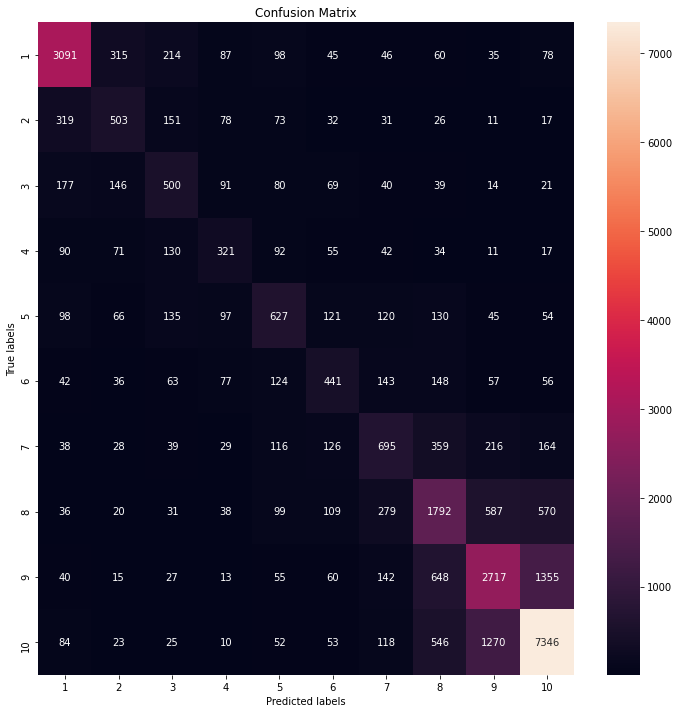

In [92]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# np.set_printoptions(precision=5)
cm = confusion_matrix(result.cpu(), preds.cpu(), labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# cm = cm/np.sum(cm, axis=1)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, ax = ax, fmt='d'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1', '2','3', '4','5', '6','7', '8','9', '10']); ax.yaxis.set_ticklabels(['1', '2','3', '4','5', '6','7', '8','9', '10']);

plt.savefig(os.path.join("/content/gdrive/My Drive/", 'dziwne_adama_cm.png'), format = 'png', dpi = 150, bbox_inches = 'tight')

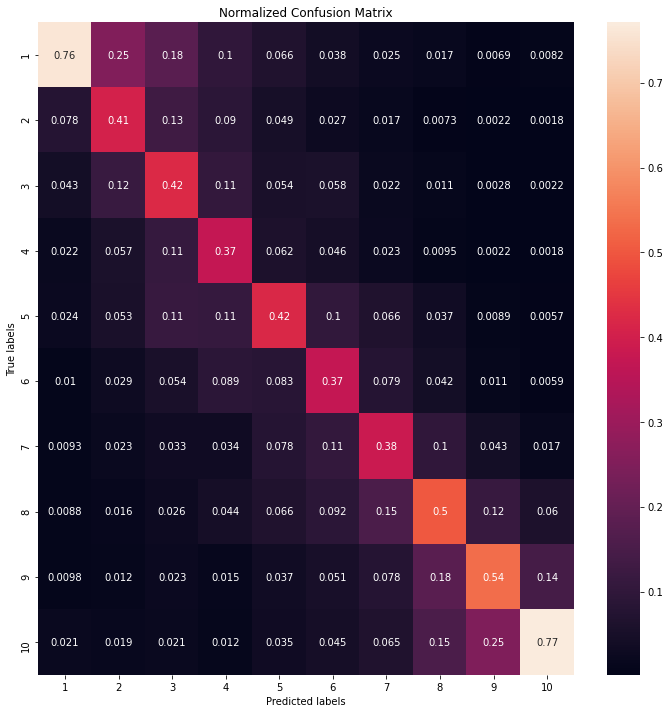

In [93]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# np.set_printoptions(precision=5)
cm = confusion_matrix(result.cpu(), preds.cpu(), labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
cm = cm/np.sum(cm, axis=1)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Normalized Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1', '2','3', '4','5', '6','7', '8','9', '10']); ax.yaxis.set_ticklabels(['1', '2','3', '4','5', '6','7', '8','9', '10']);

plt.savefig(os.path.join("/content/gdrive/My Drive/", 'dziwne_adama_cm_norm.png'), format = 'png', dpi = 150, bbox_inches = 'tight')

In [94]:
torch.sum(preds == result).item() / result.shape[0]

0.6011

In [97]:
np.mean(preds.cpu().numpy() == datasets['test'].rate)

0.10463333333333333

In [98]:
datasets['test'].rate

40802     8
97167     7
14472     7
2258      3
61557     9
         ..
122459    6
80275     6
8158      9
82488     7
100319    1
Name: rate, Length: 30000, dtype: int64

In [99]:
preds.cpu().numpy()

array([ 9,  8,  9, ..., 10,  7,  1])

In [70]:
!wget https://home.ipipan.waw.pl/p.teisseyre/TEACHING/ZMUM/DANE/TestX.csv
real_test = pd.read_csv('TestX.csv', sep = ';', encoding = 'UTF-8')
real_test_dl = processor.create_dataloader(real_test.assign(rate = 0),
                                        shuffle=False,
                                        batch_size=args.train_batch_size,
                                        valid_pct=None)

--2020-05-22 19:31:06--  https://home.ipipan.waw.pl/p.teisseyre/TEACHING/ZMUM/DANE/TestX.csv
Resolving home.ipipan.waw.pl (home.ipipan.waw.pl)... 213.135.36.238
Connecting to home.ipipan.waw.pl (home.ipipan.waw.pl)|213.135.36.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24746641 (24M) [application/octet-stream]
Saving to: ‘TestX.csv.2’

TestX.csv.2         100%[===================>]  23.60M  35.8MB/s    in 0.7s    

2020-05-22 19:31:07 (35.8 MB/s) - ‘TestX.csv.2’ saved [24746641/24746641]




Processing 50000 examples on 2 cores: 100%|██████████| 50000/50000 [01:05<00:00, 765.26it/s]


In [77]:
outputs = []

for batch in real_test_dl:
  model.eval()
  with torch.no_grad():
      batch, labels = (t.to(args.device) for t in batch)
      inputs = batch.transpose(0, 1).contiguous()
      clf_logits = model(inputs,
                          clf_tokens_mask=(inputs == clf_token),
                          padding_mask=(batch == pad_token))
      outputs.append(clf_logits)

preds = torch.cat(outputs)
preds = torch.argmax(preds, dim = 1)
preds

tensor([9, 7, 9,  ..., 8, 9, 9], device='cuda:0')

In [0]:
preds_real = preds + 1
np.savetxt(os.path.join("/content/gdrive/My Drive/", 'preds_test.csv'), preds_real.cpu().numpy())

In [73]:
int2label

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

In [60]:

for batch in real_test_dl:
  print(batch)
  break

[tensor([[ 107, 1302, 1170,  ...,    0,    0,    0],
        [ 107,  146, 1138,  ...,    0,    0,    0],
        [ 107,  146, 1138,  ...,    0,    0,    0],
        ...,
        [ 107,  146, 1108,  ...,    0,    0,    0],
        [ 107, 2857, 1103,  ...,    0,    0,    0],
        [ 107, 1258, 1606,  ...,    0,    0,    0]]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])]


In [0]:
from google.colab import files
uploaded = files.upload()

Saving drugs_test_df.csv to drugs_test_df.csv


In [0]:
fake_test = pd.read_csv('drugs_test_df.csv', sep = ';', encoding = 'UTF-8')
fake_test_dl = processor.create_dataloader(fake_test.assign(rate = 0),
                                        shuffle=False,
                                        batch_size=args.train_batch_size,
                                        valid_pct=None)

In [0]:
outputs = []
y = []

for batch in fake_test_dl:
  model.eval()
  with torch.no_grad():
      batch, labels = (t.to(args.device) for t in batch)
      inputs = batch.transpose(0, 1).contiguous()
      clf_logits = model(inputs,
                          clf_tokens_mask=(inputs == clf_token),
                          padding_mask=(batch == pad_token))
      outputs.append(clf_logits)
      y.append(labels)

preds = torch.cat(outputs)
result = torch.cat(y)

In [0]:
preds = torch.argmax(preds, dim = 1)
preds

In [0]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(preds.cpu().numpy(), result.cpu().numpy())